In [57]:
import warnings
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [58]:
class PatternFinder():
    def __init__(self, period=5):
        self.period = period
    
    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
        
    def search(self, start_date, end_date, threshold=0.98):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
        display(base)
        
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 딕셔너리
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
            sim_list.append(cos_similarity)
        return pd.Series(sim_list).sort_values(ascending=False)

    
    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        display(preds)
        print(f'pred: {preds.mean()*100} % ')

    
    def stat_prediction(self, result, period=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list)

In [59]:
p = PatternFinder()

In [60]:
p.set_stock('018700')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-03-14,161520,161520,161520,161507,0,NaN
1998-03-16,161520,161520,161520,161507,0,0.000000
1998-03-17,161520,161520,161520,161507,0,0.000000
1998-03-18,173806,173806,173806,173794,10,0.076077
1998-03-19,187028,187028,187028,187015,10,0.076073
...,...,...,...,...,...,...
2022-04-29,3890,4010,3890,3930,162913,0.011583
2022-05-02,3890,3955,3865,3950,150801,0.005089
2022-05-03,3970,4000,3900,3975,136009,0.006329


In [61]:
result = p.search('2021-09-10', '2021-09-30')

Date
2021-09-10    2625
2021-09-13    2620
2021-09-14    2630
2021-09-15    2625
2021-09-16    2635
2021-09-17    2635
2021-09-23    2920
2021-09-24    2880
2021-09-27    2955
2021-09-28    2995
2021-09-29    2975
2021-09-30    3020
Name: Close, dtype: int64

In [62]:
pred = p.stat_prediction(result)
pred

array([ 0.06733601, -0.01124373,  0.00517852,  0.        ,  0.        ,
       -0.00288827, -0.01440996, -0.00021833,  0.00531945,  0.03402142,
        0.00472001, -0.02052574,  0.00670564,  0.09559623])

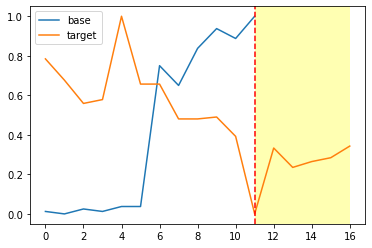

Date
2006-10-10    0.147195
2006-10-11   -0.037732
2006-10-12    0.011805
2006-10-13    0.007710
2006-10-16    0.023105
Name: Change, dtype: float64

pred: 3.0416592432346534 % 


In [63]:
p.plot_pattern(2138)

In [64]:

import ipywidgets as widgets
from IPython.display import display, clear_output

# !jupyter nbextension enable --py widgetsnbextension --sys-prefix
# !jupyter serverextension enable voila --sys-prefix

In [65]:
start_date = widgets.DatePicker(description='시작일')
end_date = widgets.DatePicker(description='종료일')

In [66]:
# button send
search_button = widgets.Button(
                description='예측하기',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output = widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()
        p = PatternFinder()
        p.set_stock(code.value)
        result = p.search(start_date.value.strftime('%Y-%m-%d'), end_date.value.strftime('%Y-%m-%d'))
        print(result)
        for idx in result.keys():
            p.plot_pattern(idx)
        
search_button.on_click(on_button_clicked)

vbox_result = widgets.VBox([search_button, output])

In [67]:
label_headline = widgets.Label(
                    value='Photo by CDC on Unsplash',
                )

vbox_headline = widgets.VBox([label_headline])

In [68]:
text_0 = widgets.HTML(value="<h2>종목 코드</h2>")
text_1 = widgets.HTML(value="<h2>날짜 선택</h2>")
text_2 = widgets.HTML(value="<h2>패턴 예측</h2>")

code = widgets.Text(placeholder='종목코드를 입력해 주세요')
code.value = '035720'

vbox_0 = widgets.VBox([text_0, code])
vbox_1 = widgets.VBox([text_1,start_date, end_date ])
vbox_2 = widgets.VBox([text_2, vbox_result])

In [56]:
page = widgets.VBox([vbox_0, vbox_1 , vbox_2])
display(page)